# Initialization cells
Follows are initialization cells to
- Reset the package directory
- Reload the k-seq package

Some updates need to be done manually:
- If any change made in the object, all inherent objects needs to be reassigned

In [5]:
import sys
import numpy as np
# add package directory to the top of sys.path
if np.sum([dirc.find('k-seq') >= 0 for dirc in sys.path]) == 0:
    sys.path = ['/home/yuning/Work/k-seq/src/'] + sys.path

import util
import importlib
import data.bfo as data
importlib.reload(data) # refresh data module

<module 'data.bfo' from '/home/yuning/Work/k-seq/src/data/bfo.py'>

# Overview of the samples
## Read sample data from count files

In [7]:
sampleSet = data.load_all_samples()
print(util.color.BOLD + util.color.BLUE + 
      'k-seq sample data generated from raw count files'
      + util.color.END)
help(sampleSet[0])

k-seq sample data generated from raw count files
Help on Sample in module data.bfo object:

class Sample(builtins.object)
 |  This class defines and describe the samples from k-seq experiments
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_seq_fraction(self, blackList=None)
 |  
 |  get_seq_length(self)
 |  
 |  import_count_file(self, dirc, sampleType='reacted')
 |      :param dirc:
 |      :param sampleType:
 |      :return:
 |  
 |  survey_ext_std(self, stdSeq='AAAAACAAAAACAAAAACAAA', maxDist=10)
 |      This method will survey the spike in sequences in each sample
 |      :param stdSeq:
 |      :return:
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)



## List sample overview

Overview of k-seq samples
|index|sample name| total counts | unique counts | ext. std. counts | ext. std. percent|
|:--:|:-----:|:-----:|:----:|:----:|:-----:|
|1|R4A-inputA_S1_counts.txt|2165970|330565|395313|0.183|
|2|R4A-1250A_S2_counts.txt|2006578|29455|306473|0.153|
|3|R4A-250A_S3_counts.txt|1845900|23911|253806|0.137|
|4|R4A-50A_S4_counts.txt|2617260|43687|429752|0.164|
|5|R4A-10A_S5_counts.txt|1515552|26410|332480|0.219|
|6|R4A-2A_S6_counts.txt|1580503|24362|435206|0.275|
|7|R4A-0A_S7_counts.txt|2948173|2825|2670604|0.906|
|8|R4A-inputB_S8_counts.txt|1257100|174225|288920|0.230|
|9|R4A-1250B_S9_counts.txt|3451114|42691|571243|0.166|
|10|R4A-250B_S10_counts.txt|10273787|120423|1248636|0.122|
|11|R4A-50B_S11_counts.txt|2544354|56718|312962|0.123|
|12|R4A-10B_S12_counts.txt|2401143|65885|336523|0.140|
|13|R4A-2B_S13_counts.txt|1913930|41178|377658|0.197|
|14|R4A-0B_S14_counts.txt|2545559|2201|2321614|0.912|
|15|R4B-inputA_S15_counts.txt|2546171|491652|692277|0.272|
|16|R4B-1250A_S1

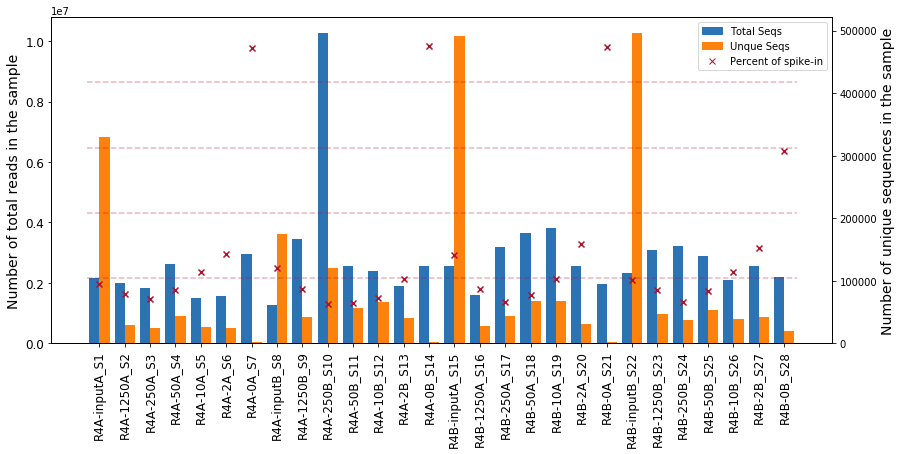

In [266]:
import util
print(util.color.BOLD + util.color.BLUE + 
      'Overview of k-seq samples'
      + util.color.END)

data.print_sample_overview(sampleSet, table=True, figures=True)

In [9]:
from IPython.display import HTML

s = """
<table>
<tr>
<th> {:,} </th>
<th> column 2 </th>
</tr>
</table>
""".format(1020312301)
display(HTML(s))

"1,020,312,301",column 2


## Distribution of input pool

Sequence length distribution in each sample


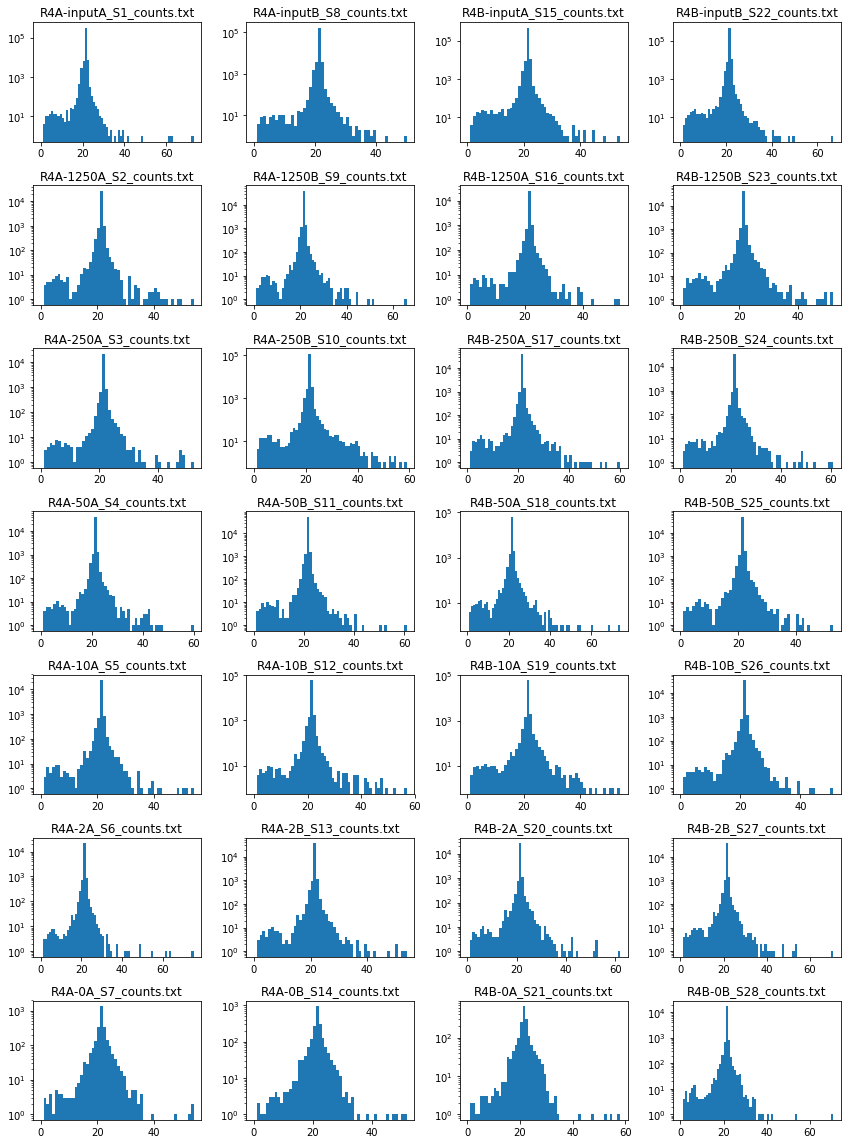

In [196]:
print(util.color.BOLD + util.color.BLUE + \
'Sequence length distribution in each sample' + util.color.END)
data.print_length_dist(sampleSet)

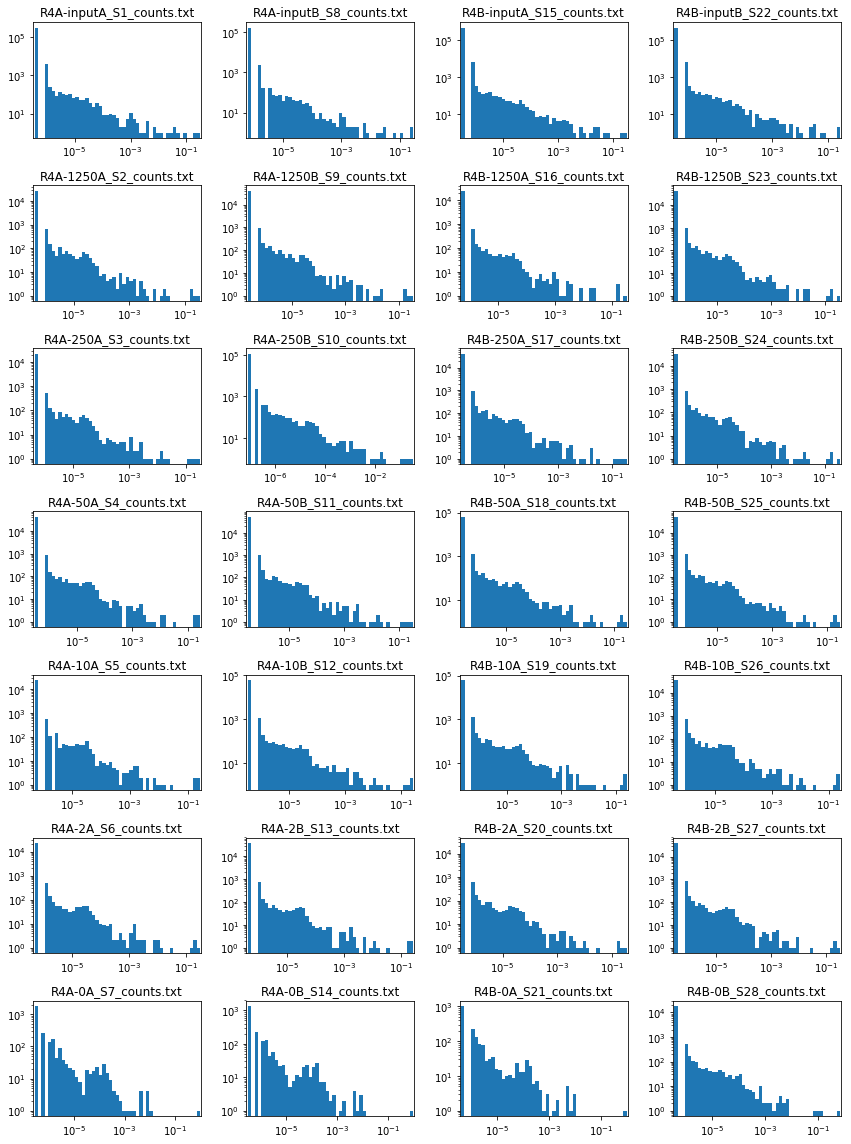

In [231]:
fig, axes = plt.subplots(7, 4, figsize=[12, 16])
for ix in range(28):
    ax = axes[ix % 7, int(ix / 7)]
    fractions = sampleSet[ix].get_seq_fraction()
    bins = np.logspace(np.log10(np.min(fractions)*0.8), np.log10(np.max(fractions)*1.1), 50)
    ax.hist(fractions, bins=bins)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlim(np.min(fractions)*0.7, np.max(fractions)*1.2)
    # ax.set_ylim(1, 10e5)
    ax.set_title(sampleSet[ix].id)
plt.tight_layout()
plt.show()

Use entropy efficiency to describe the distribution of sequences


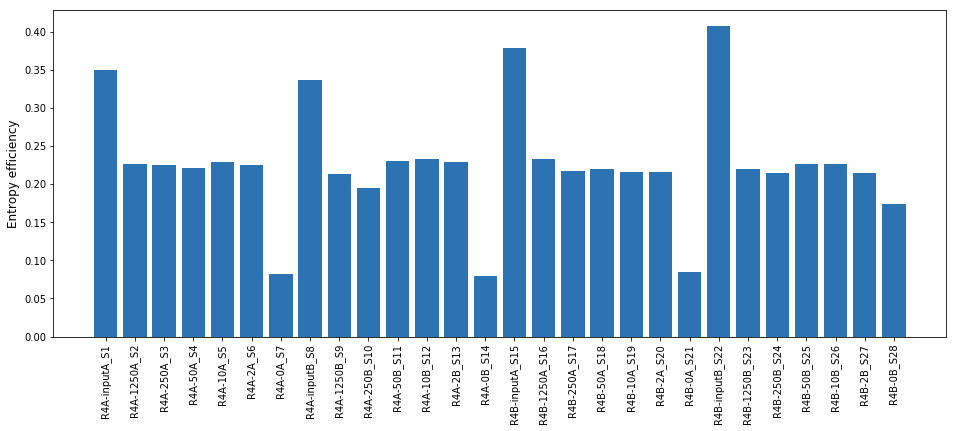

In [263]:
print(util.color.BOLD + util.color.BLUE + \
'Use entropy efficiency to describe the distribution of sequences' + util.color.END)


def bootstrap_fractions(fractions, size, depth=200):
    import numpy as np
    
    efficiencyList = []
    for _ in range(depth):
        sampleBootstrapped = np.random.choice([i for i in range(len(fractions))], p=fractions, replace=True, size=size)
        unique, counts = np.unique(sampleBootstrapped, return_counts=True)
        res = dict(zip(unique, counts))
        fractionsNew = [res[i]/size if i in res.keys() else 0 for i in range(len(fractions))]
        efficiencyList.append(-np.nansum(np.multiply(fractionsNew, np.log2(fractionsNew)))/np.log2(len(fractionsNew)))
    
    return efficiencyList

efficiencyList = bootstrap_fractions(sampleSet[0].get_seq_fraction(blackList='AAAAACAAAAACAAAAACAAA'), sampleSet[0].totalSeq)


fig = plt.figure(figsize=[16, 6])
ax = fig.add_subplot(111)

for ix in range(28):
    fractions = sampleSet[ix].get_seq_fraction()
    entropy_efficiency = -np.sum(np.multiply(fractions, np.log2(fractions)))/np.log2(len(fractions))
    plt.bar([ix], [entropy_efficiency], width=0.8, color='#2C73B4')

ax.set_xticks([i for i in range(28)])
ax.set_xticklabels([sample.id[:sample.id.find('_counts')] for sample in sampleSet], rotation=90)
ax.set_ylabel('Entropy efficiency', fontsize=12)
plt.show()

## distribution of external standard

Distribution of external standard peak


/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/ipykernel/__main__.py:36: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


<Figure size 432x288 with 0 Axes>

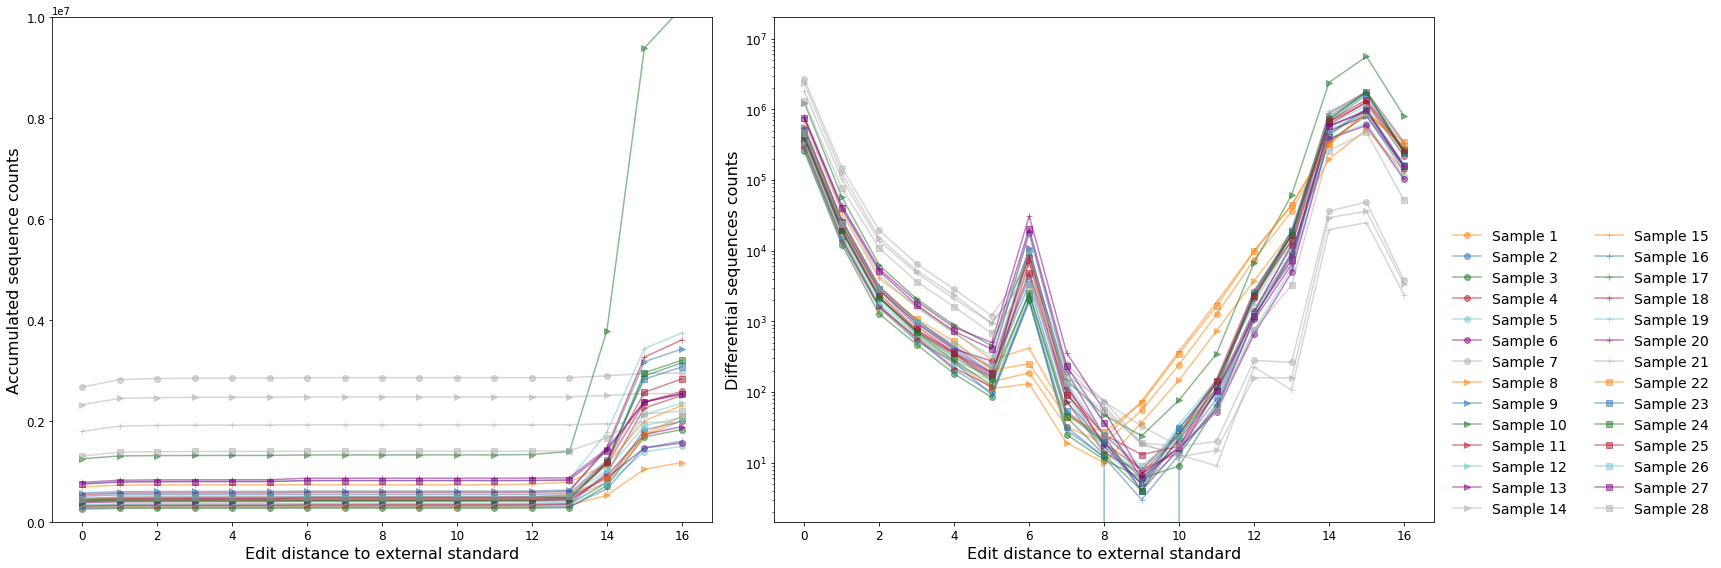

In [3]:
import util
print(util.color.BOLD + util.color.BLUE + 
      'Distribution of external standard peak'
      + util.color.END)

def plot_all(sampleSet):
    import matplotlib.pyplot as plt
    
    markerList = ['-o', '->', '-+', '-s']
    colorList = ['#FC820D', '#2C73B4', '#1C7725', '#B2112A', '#70C7C7', '#810080', '#AEAEAE']
    symbolList = []
    for marker in markerList:
        symbolList += [marker for i in range(7)]
    plt.figure()
    fig, ax = plt.subplots(1,2, figsize=[24,8])
    
    for sampleIx,sample in enumerate(sampleList):
        ax[0].plot([i for i in range(maxDist+1)], extStdCountList[sampleIx],
                   symbolList[sampleIx], color=colorList[sampleIx%7], label='Sample %i' %(sampleIx+1), alpha=0.5)
    ax[0].set_xlabel('Edit distance to external standard', fontsize=16)
    ax[0].tick_params(labelsize=12)
    ax[0].set_ylim([0, 10**7])
    ax[0].set_ylabel('Accumulated sequence counts', fontsize=16)
    
    for sampleIx,sample in enumerate(sampleList):
        diffList = [extStdCountList[sampleIx][0]] + \
                   [extStdCountList[sampleIx][i+1] - extStdCountList[sampleIx][i] for i in range(maxDist)]
        ax[1].plot([i for i in range(maxDist+1)], diffList,
                   symbolList[sampleIx], color=colorList[sampleIx % 7], label='Sample %i' %(sampleIx+1), alpha=0.5)
    ax[1].set_xlabel('Edit distance to external standard', fontsize=16)
    ax[1].tick_params(labelsize=12)
    ax[1].set_yscale('log')
    ax[1].set_ylim([0, 2*10**7])
    ax[1].legend(loc=[1.02,0], fontsize=14, frameon=False, ncol=2)
    ax[1].set_ylabel('Differential sequences counts', fontsize=16)
    plt.tight_layout()
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/extStdErr.jpeg', dpi=300)
    plt.show()

plot_all()

# Get q-factor

In [23]:
from util import color as color
print(color.BOLD + color.BLUE + \
'Calculate quantification factor based on spike-in' + color.END)

import importlib
import k_seq.k_seq as k_seq
importlib.reload(k_seq)
import util

stdSeq = 'AAAAACAAAAACAAAAACAAA'
maxDist = 2
fmol = []
for i in range(4):
    fmol += [4130, 1240, 826, 413, 207, 82.6, 41.3]

qFactorList = [[sample, k_seq.get_q_factor(root+sample, std = stdSeq, amount = fmol[sampleIx], maxDist=maxDist)] 
               for sampleIx, sample in enumerate(sampleList)]
    
util.dump_pickle(qFactorList, '/mnt/storage/projects/ribozyme_predict/bfo/qFactorList_ed2_new.pkl',
                 log='The NEW q_factor (reciprical of the old one) based on external spike-in, within edit distance 2, using k_seq.k_seq.get_q_factor(maxDict=2). Format: [sampleName, (qfactor, stanrdCounts, Total counts)]',
                 overwrite=False)

Calculate quantification factor based on spike-in
File exist, do you want to overwrite? (Y/N)Y
Data has been saved to /mnt/storage/projects/ribozyme_predict/bfo/qFactorList_ed2_new.pkl


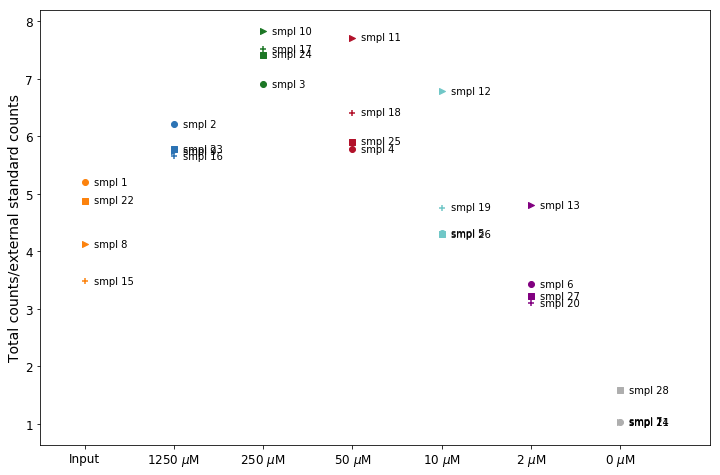

In [60]:
import matplotlib.pyplot as plt
import plot
rndToCal = [[i+1, i+8, i+15, i+22] for i in range(7)]

fig = plt.figure(figsize=[12,8])
ax = fig.add_subplot(111)
markerList = ['o', '>', '+', 's']
colorList = ['#FC820D', '#2C73B4', '#1C7725', '#B2112A', '#70C7C7', '#810080', '#AEAEAE']
    
for ix, rndBatch in enumerate(rndToCal):
    for rndIx,rnd in enumerate(rndBatch):
        ax.scatter(ix, qFactorList[rnd-1][2]/qFactorList[rnd-1][1], marker=markerList[rndIx], color=colorList[ix])
        ax.text(s='smpl %i' %rnd, x=ix+0.1, y=qFactorList[rnd-1][2]/qFactorList[rnd-1][1], va='center', fontsize=10)
ax.set_xlim([-0.5, 7])
ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
ax.set_xticklabels(['Input', r'1250 $\mu$M', r'250 $\mu$M', r'50 $\mu$M', r'10 $\mu$M', r'2 $\mu$M', r'0 $\mu$M'], fontsize=12)
ax.set_ylabel('Total counts/external standard counts', fontsize=14)
plot.set_ticks_size(ax,fontSizeY=12)

plt.show()

# Get sequence info
## Read in the input/initial pool
- Different from BYO selection, there are two input pool measures in BFO concentration for each selection. Thus, we need to adjust the method to construct the initial pool composition

In [5]:
import numpy as np

def read_initPool(initDircs):
    '''
    Read the sequences detected in the initial pool, and return a dictionary of sequences
    :param initDirc: directory to the count file of initial pool
    :return: candidList: a dictionary of all sequences detected in the initial pool
    '''
    for ix,initDirc in enumerate(initDircs):
        with open(initDirc) as file:
            next(file)
            next(file)
            next(file)
            for line in file:
                seq = line.strip().split()
                if not seq[0] in candidList.keys():
                    candidList[seq[0]] = {
                        'initRaw': [np.nan for i in range(4)],
                        'kSeqRaw': [np.nan for i in range(20)],
                        'negStdRaw': [np.nan for i in range(4)]
                    }
                candidList[seq[0]]['initRaw'][ix] = int(seq[1])
    print('Candidate sequences imported from initial pool')
    return candidList

def align_samples(candidList, sampleDircList):
    """
    Survey sequence counts in each k-seq sample and add raw counts of sequences in candidList to the list
    :param candidList: sequences detected in initial pool
    :param sampleDircList: directories to the k-seq sample count file
    :param validSampleList: A list of valid samples
    :return: an updated candidList with raw counts from valid k-seq samples
    """
    for sampleIx, sampleDirc in enumerate(sampleDircList):
        print('Surveying sequences in sample %s ...' %sampleDirc)
        with open(root + sampleDirc) as file:
            next(file)
            next(file)
            next(file)
            for line in file:
                seq = line.strip().split()
                if seq[0] in candidList.keys():
                    candidList[seq[0]]['kSeqRaw'][sampleIx] = int(seq[1])

    return candidList


def align_negStd(candidList, sampleDircList):
    """
    Survey sequence counts in each k-seq sample and add raw counts of sequences in candidList to the list
    :param candidList: sequences detected in initial pool
    :param sampleDircList: directories to the k-seq sample count file
    :param validSampleList: A list of valid samples
    :return: an updated candidList with raw counts from valid k-seq samples
    """
    for sampleIx, sampleDirc in enumerate(sampleDircList):
        print('Surveying sequences in sample %s ...' %sampleDirc)
        with open(root + sampleDirc) as file:
            next(file)
            next(file)
            next(file)
            for line in file:
                seq = line.strip().split()
                if seq[0] in candidList.keys():
                    candidList[seq[0]]['negStdRaw'][sampleIx] = int(seq[1])

    return candidList

initDircs = [
    '/mnt/storage/projects/ribozyme_predict/bfo/counts/R4A-inputA_S1_counts.txt',
    '/mnt/storage/projects/ribozyme_predict/bfo/counts/R4A-inputB_S8_counts.txt',
    '/mnt/storage/projects/ribozyme_predict/bfo/counts/R4B-inputA_S15_counts.txt',
    '/mnt/storage/projects/ribozyme_predict/bfo/counts/R4B-inputB_S22_counts.txt'
]
candidList = {}
candidList = read_initPool(initDircs)

root = '/mnt/storage/projects/ribozyme_predict/bfo/counts/'
sampleDircList = [sampleName for sampleName in sampleList if sampleName.find('input')==-1 and sampleName.find('-0')==-1]
candidList = align_samples(candidList, sampleDircList)
sampleDircList = [sampleName for sampleName in sampleList if sampleName.find('-0')>-1]
candidList = align_negStd(candidList, sampleDircList)

Candidate sequences imported from initial pool
Surveying sequences in sample R4A-1250A_S2_counts.txt ...
Surveying sequences in sample R4A-250A_S3_counts.txt ...
Surveying sequences in sample R4A-50A_S4_counts.txt ...
Surveying sequences in sample R4A-10A_S5_counts.txt ...
Surveying sequences in sample R4A-2A_S6_counts.txt ...
Surveying sequences in sample R4A-1250B_S9_counts.txt ...
Surveying sequences in sample R4A-250B_S10_counts.txt ...
Surveying sequences in sample R4A-50B_S11_counts.txt ...
Surveying sequences in sample R4A-10B_S12_counts.txt ...
Surveying sequences in sample R4A-2B_S13_counts.txt ...
Surveying sequences in sample R4B-1250A_S16_counts.txt ...
Surveying sequences in sample R4B-250A_S17_counts.txt ...
Surveying sequences in sample R4B-50A_S18_counts.txt ...
Surveying sequences in sample R4B-10A_S19_counts.txt ...
Surveying sequences in sample R4B-2A_S20_counts.txt ...
Surveying sequences in sample R4B-1250B_S23_counts.txt ...
Surveying sequences in sample R4B-250B_

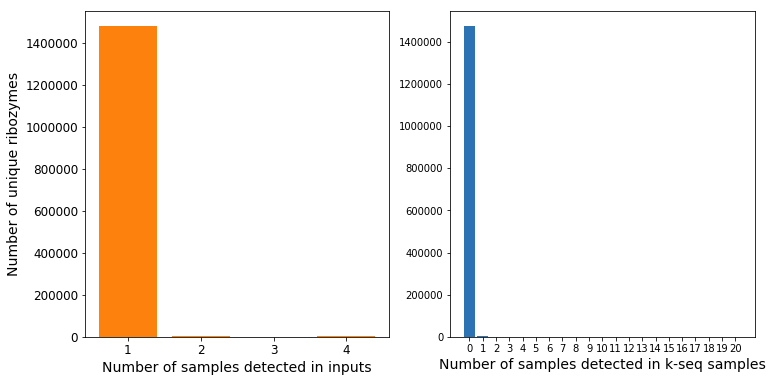

In [44]:
def coverage_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    fig, ax = plt.subplots(1, 2, figsize=[12,6])
    
    pos = [i+1 for i in range(4)]
    initCoverage = [0 for i in range(5)]
    for res in surveyRes[0]:
        initCoverage[int(res)] += 1
    
    ax[0].bar(pos, initCoverage[1:], color='#FC820D')
    ax[0].set_xticks(pos)
    plot.set_ticks_size(ax[0])
    ax[0].set_xlabel('Number of samples detected in inputs', fontsize=14)
    ax[0].set_ylabel('Number of unique ribozymes', fontsize=14)
    
    
    pos = [i for i in range(21)]
    kSeqCoverage = [0 for i in range(21)]
    for res in surveyRes[1]:
        kSeqCoverage[int(res)] += 1
    ax[1].bar(pos, kSeqCoverage, color='#2C73B4')
    ax[1].set_xticks(pos)
    plot.set_ticks_size(ax[0])
    ax[1].set_xlabel('Number of samples detected in k-seq samples', fontsize=14)
    # ax[1].set_ylabel('Number of unique ribozymes', fontsize=14)
    
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_coverage.png', dpi=300)
    plt.show()
    
coverage_plot(surveyRes)

In [29]:
kSeqCoverage = [0 for i in range(21)]
for res in surveyRes[1]:
    kSeqCoverage[int(res)] += 1
kSeqCoverage

[1475084,
 3769,
 925,
 579,
 436,
 338,
 263,
 250,
 212,
 209,
 179,
 160,
 152,
 109,
 116,
 103,
 110,
 89,
 101,
 167,
 819]

In [20]:
def survey_coverage_mix(candidList, blackList):
    surveyRes = [[np.nansum([1 for i in res['initRaw'] if i>0], dtype=np.int32),
                  np.nansum([1 for ix,i in enumerate(res['kSeqRaw']) if i>0 and not ix in blackList], dtype=np.int32),
                  np.nanmedian(res['initRaw']),
                  np.nanmedian(res['kSeqRaw'])] for res in candidList.values()]
    return surveyRes

blackList = [5, 11, 17, 23]
surveyRes = np.array(survey_coverage_mix(candidList, blackList)).T

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


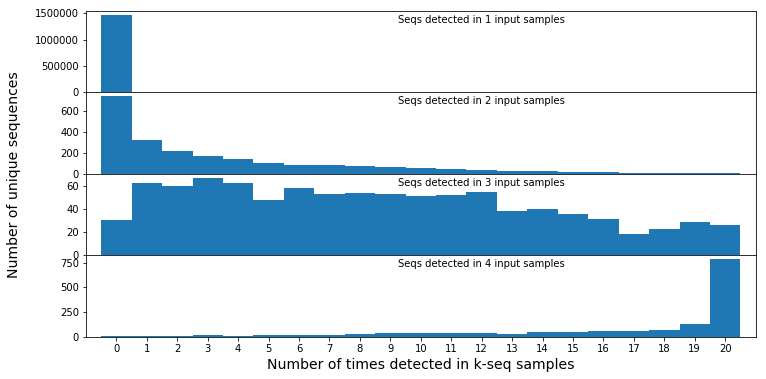

In [35]:
import matplotlib.pyplot as plt

fig,ax = plt.subplots(4, 1, figsize=[12,6], sharex=True)
plt.subplots_adjust(wspace=0, hspace=0)
bins = [i for i in range(25)]

for ix in range(4):
    ax[ix].hist([surveyRes[1][seq] for seq in range(len(surveyRes[0])) if surveyRes[0][seq]==(ix+1)], bins=bins, align='left')
    ax[ix].text(s='Seqs detected in %i input samples' %(ix+1), x=12, y=ax[ix].get_ylim()[1]*0.95, ha='center', va='top', fontsize=10)

ax[3].set_xticks([i for i in range(21)])
ax[3].set_xlabel('Number of times detected in k-seq samples', fontsize=14)
fig.text(s='Number of unique sequences', x=0.05, y=0.5, ha='right', va='center', fontsize=14, rotation=90)
ax[3].set_xlim([-1, 21])

plt.show()

In [15]:
seqToFit = [
    {
        'seq':seq[0],
        'initRaw':seq[1]['initRaw'],
        'kSeqRaw':seq[1]['kSeqRaw'],
        'negStdRaw':seq[1]['negStdRaw']
    }
    for seq in candidList.items() if np.nansum(seq[1]['kSeqRaw'])>0
]


In [25]:


seq

[2006578,
 1845900,
 2617260,
 1515552,
 1580503,
 3451114,
 10273787,
 2544354,
 2401143,
 1913930,
 1616904,
 3186048,
 3661612,
 3801335,
 2569754,
 3102130,
 3230772,
 2878311,
 2101362,
 2562117]

In [28]:
def get_normalized_fraction(seqToFit, qFactorList):
    """
    :param seqToFit: list of sequences will pass to fitting
    :param sampleTotals: list of total counts of reads in samples
    :param qFactors:
    :return:
    """
    import numpy as np
    
    sampleTotals = np.array([sample[1][2] for sample in qFactorList if sample[0].find('input')==-1 and sample[0].find('-0')==-1])
    qFactors = np.array([sample[1][0] for sample in qFactorList if sample[0].find('input')==-1 and sample[0].find('-0')==-1])
    for seq in seqToFit:
        seq['kSeqFmol'] = np.array(seq['kSeqRaw'])/sampleTotals*qFactors
    
    sampleTotals = np.array([sample[1][2] for sample in qFactorList if sample[0].find('input')>0])
    qFactors = np.array([sample[1][0] for sample in qFactorList if sample[0].find('input')>0])
    for seq in seqToFit:
        seq['initFmol'] = np.array(seq['initRaw'])/sampleTotals*qFactors
    
    return seqToFit

seqToFit = get_normalized_fraction(seqToFit, qFactorList)

In [71]:
def get_pct_median_error(a):
    import numpy as np
    median = np.nanmedian(a)
    return np.nanmedian(np.abs(a-median)/median)

pmeList = [[], [], [], [], []]
for seq in seqToFit:
    pme = get_pct_median_error(seq['initFmol'])
    pmeList[np.sum(~np.isnan(seq['initFmol']), dtype=np.int32)].append(pme)

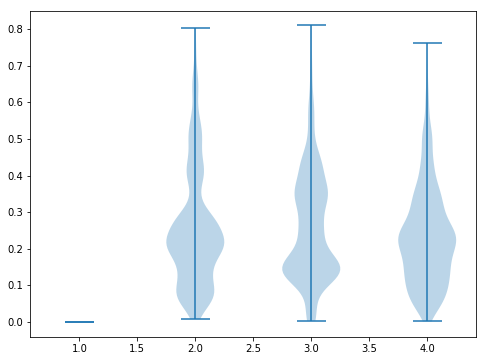

In [72]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[8, 6])
ax = fig.add_subplot(111)
ax.violinplot(pmeList[1:])
plt.show()

/home/yuning/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


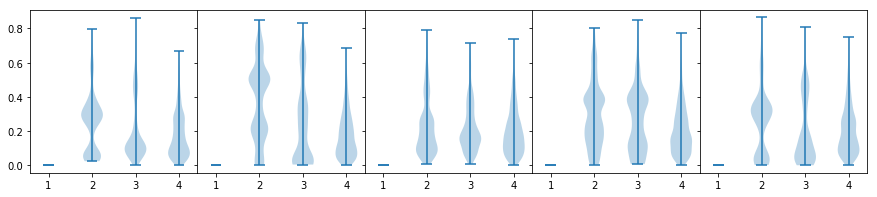

In [67]:
def get_pct_median_error(a):
    import numpy as np
    median = np.nanmedian(a)
    return np.nanmedian(np.abs(a-median)/median)

fig, axes = plt.subplots(1, 5, figsize=[15, 3], sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)

for concen in [0, 1, 2, 3, 4]:
    pmeList = [[], [], [], [], []]
    for seq in seqToFit:
        pme = get_pct_median_error(np.array([i for ix,i in enumerate(seq['kSeqFmol']) if ix%5==concen]))
        pmeList[np.sum(~np.isnan([i for ix,i in enumerate(seq['kSeqFmol']) if ix%5==concen]), dtype=np.int32)].append(pme)
    axes[concen].violinplot(pmeList[1:])
    
plt.show()

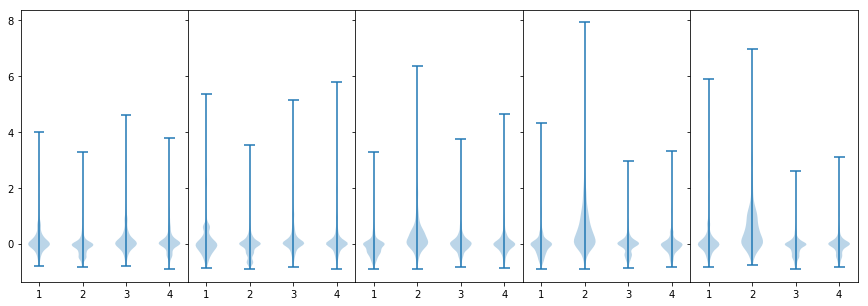

In [107]:
def get_pct_median_error(a):
    import numpy as np
    median = np.nanmedian(a)
    return (a-median)/median

fig, axes = plt.subplots(1, 5, figsize=[15, 5], sharey=True)
plt.subplots_adjust(hspace=0, wspace=0)

for concen in [0, 1, 2, 3, 4]:
    pmeList =[]
    for seq in seqToFit:
        concenList = np.array([i for ix,i in enumerate(seq['kSeqFmol']) if ix%5==concen])
        if np.nansum(~np.isnan(concenList)) >= 3:
            pmeList.append(get_pct_median_error(concenList))
    pmeList = np.array(pmeList).T
    pmeList = [pme[~np.isnan(pme)] for pme in pmeList]
    axes[concen].violinplot(pmeList)
    
plt.show()

In [108]:
for seq in seqToFit:
    seq['reactedFrac'] = seq['kSeqFmol']/np.nanmedian(seq['initFmol'])

In [109]:
util.dump_pickle(data=seqToFit,
                 dirc='/mnt/storage/projects/ribozyme_predict/bfo/seqToFit.pkl',
                 log='Selected sequence to be fit, reacted fractions are calculated',
                 overwrite=False)

Data has been saved to /mnt/storage/projects/ribozyme_predict/bfo/seqToFit.pkl


In [110]:
seqToFit[0]

{'initFmol': array([6008.41323318, 4466.98776336, 3002.13014749, 4653.7642833 ]),
 'initRaw': [605843, 329164, 531449, 540204],
 'kSeqFmol': array([2398.03005608, 1690.5003274 ,  593.10103482,  179.02229768,
          50.5293381 , 2205.07395808, 2134.33522443,  926.29377392,
         356.51019993,   85.28365579, 2153.7197774 , 2017.25009309,
         714.62291698,  221.94011948,   45.01485271, 2306.5592552 ,
        2071.48756649,  640.31583485,  188.25630226,   51.41843473]),
 'kSeqRaw': [624126,
  546971,
  650718,
  303851,
  281969,
  1069139,
  3391792,
  739631,
  609722,
  411664,
  497181,
  1036256,
  988301,
  856067,
  452499,
  998197,
  1092010,
  755244,
  444605,
  494326],
 'negStdRaw': [23699, 14626, 10047, 276180],
 'reactedFrac': array([0.52584042, 0.37069319, 0.13005529, 0.03925604, 0.01108008,
        0.48352898, 0.46801738, 0.20311785, 0.07817561, 0.01870101,
        0.47226802, 0.44234293, 0.15670263, 0.04866707, 0.00987086,
        0.50578269, 0.45423613, 0.1404

# Fitting results

In [275]:
fittingRes = util.load_pickle(dirc='/mnt/storage/projects/ribozyme_predict/bfo/fittingRes_bfo_deep.pkl')

fittingRes_bfo_deep.pkl:
Fitting results of BFO data, including the CI 95 estimation using 1000 bootstrap, on Pod (40 cores)


In [120]:
fittingRes[0]

{'ci95': array([[  0.46826103,   0.58255285,   0.83353387,   0.60058596],
        [ 83.91915833, 192.97612739, 322.37153632, 192.99796954],
        [ 64.43580405, 110.33351415, 172.97394266, 112.03204698]]),
 'initFmol': array([6008.41323318, 4466.98776336, 3002.13014749, 4653.7642833 ]),
 'initRaw': [605843, 329164, 531449, 540204],
 'kSeqFmol': array([2398.03005608, 1690.5003274 ,  593.10103482,  179.02229768,
          50.5293381 , 2205.07395808, 2134.33522443,  926.29377392,
         356.51019993,   85.28365579, 2153.7197774 , 2017.25009309,
         714.62291698,  221.94011948,   45.01485271, 2306.5592552 ,
        2071.48756649,  640.31583485,  188.25630226,   51.41843473]),
 'kSeqRaw': [624126,
  546971,
  650718,
  303851,
  281969,
  1069139,
  3391792,
  739631,
  609722,
  411664,
  497181,
  1036256,
  988301,
  856067,
  452499,
  998197,
  1092010,
  755244,
  444605,
  494326],
 'negStdRaw': [23699, 14626, 10047, 276180],
 'params': [0.4981928489825576, 185.8463592227381

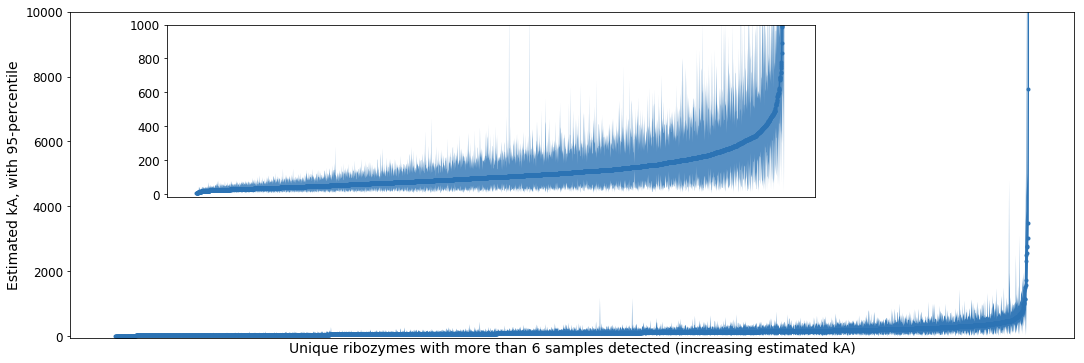

In [183]:
def filter_fn(res, percentile=True):
    if percentile:
        return [res['ci95'][2][3], res['ci95'][2][0], res['ci95'][2][2]]
    else:
        return [res['params'][2], res['params'][2]-2*res['stdevs'][2], res['params'][2]+2*res['stdevs'][2]]


def value_plot(surveyRes):
    import matplotlib.pyplot as plt
    import plot
    
    lowest = 0.01
    highest = 10
    
    fig = plt.figure(figsize=[18,6])
    ax = fig.add_subplot(111)
    ax.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    ax.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.95, facecolor='#2C73B4')
    plot.set_ticks_size(ax)
    ax.set_ylim([-50, 10000])
    ax.set_ylabel('Estimated kA, with 95-percentile', fontsize=14)
    ax.set_xticks([])
    ax.set_xlabel('Unique ribozymes with more than 6 samples detected (increasing estimated kA)', fontsize=14)
    axInset = fig.add_axes([0.2, 0.45, 0.5, 0.4])
    axInset.plot([i for i in range(len(surveyRes))], [res[0] for res in surveyRes], '.-', color='#2C73B4')
    axInset.fill_between([i for i in range(len(surveyRes))],
                    y1=[res[1] for res in surveyRes],
                    y2=[res[2] for res in surveyRes],
                    alpha=0.80, facecolor='#2C73B4')
    plot.set_ticks_size(axInset)
    axInset.set_ylim([-20, 1000])
    axInset.set_xticks([])
    
    # ax.set_xlim([25600,25750])
    # fig.savefig('/home/yuning/Work/ribozyme_pred/fig/ci_est/bto_res_values_larg6_normality.png', dpi=300)
    plt.show()

surveyRes = []
# Only survey ribozymes at least detected 6 times and the CI can be estimated, return prediction and CI
for res in fittingRes:
    if np.sum(~np.isnan(res['kSeqFmol'])) >= 6 and ~np.isnan(res['params'][2]):
        if ~np.isnan(res['ci95'][2][1]):
            surveyRes.append(filter_fn(res))
sort_fn = lambda a: (a[0])
surveyRes.sort(key=sort_fn)

value_plot(surveyRes)

In [185]:
len(surveyRes)

3039

In [175]:
def get_config(res):
    return np.sum(~np.isnan(res['kSeqFmol'].reshape(4, 5)), axis=0)

def sort_fn(res):
    if np.isnan(res['params'][2]):
        return (0, 0)
    elif len(res['ci95'])==1:
        return (1, 0)
    else:
        return (1, res['ci95'][2][1])


def export_csv(fittingRes, dirc):
    fittingRes.sort(key=sort_fn, reverse=True)
    with open(dirc, 'w') as output:
        output.write('seq,inputCountMedian,config,kAEstimate,CIEstimate,k,A,kA,kA2.5,kA50,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean\n')
        for res in fittingRes:
            output.write('%s,%i,%s,' %(res['seq'], np.nanmedian(res['initRaw']), get_config(res)))
            if np.isnan(res['params'][2]):
                output.write('0,0,%s\n' %(','.join(['nan' for i in range(15)])))
            elif len(res['ci95'])==1:
                output.write('1,0,%f,%f,%f,%s\n' %(res['params'][0], res['params'][1], res['params'][2], ','.join(['nan' for i in range(12)])))
            else:
                output.write('1,1,%f,%f,%f,%s\n' %(res['params'][0], res['params'][1], res['params'][2],
                                                    ','.join(['%f'%i for i in list(res['ci95'][2]) + list(res['ci95'][0]) + list(res['ci95'][1])])))

export_csv(fittingRes, dirc='/mnt/storage/projects/ribozyme_predict/bfo/fittingRes.csv')

In [1]:
import pandas as pd

df = pd.read_csv('/mnt/storage/projects/ribozyme_predict/k_seq/fittingRes_deep.csv')

In [34]:
def filter_fn(seq):
    return np.sum([int(seq[1]['config'][i]) for i in [1,3,5,7]])>=6

dfNew = df[[filter_fn(seq) for seq in df.iterrows()]]

In [38]:
dfNew.sort_values(by='kA', ascending=False)

,seq,inputCount,config,kAEstimate,CIEstimate,k,A,kA,kSD,ASD,...,kA97.5,kAMean,k2.5,k50,k97.5,kMean,A2.5,A50,A97.5,AMean
39,TGATTTCAAGCAATCGGTCTG,1,[3 1 2 0],1,1,47393.092714,0.023731,1124.681409,18558.252350,0.005864,...,1361.143523,521.758719,336.607840,22355.410823,44230.315533,21636.397353,0.014261,0.025108,0.037842,0.025552
0,CCAAAACTTCAAACAATCGGTC,6,[6 5 3 4],1,1,715.681578,1.000000,715.681578,14192.261172,0.128773,...,9981.876047,3705.642877,281.647950,2350.794557,11038.902086,4638.638897,0.485171,1.000000,1.000000,0.963271
1,CCGCTTCAAATCGGTTTG,1,[4 3 1 4],1,1,588.307672,1.000000,588.307672,14476.015536,0.142513,...,6712.771984,2739.551729,309.639914,2205.351800,7419.087659,3769.991121,0.342088,1.000000,1.000000,0.964377
513,ACTTCAAACAATCGATCGGCA,1,[1 3 2 0],1,1,37924.521060,0.011610,440.293696,18449.329375,0.002689,...,638.036378,254.122432,335.333375,13614.048748,44350.154713,21437.002189,0.008136,0.012399,0.018362,0.012786
3,CTACTTCAAATCGGTCTG,2,[5 4 0 4],1,1,408.258222,1.000000,408.258222,15852.336184,0.210323,...,2712.748157,1418.313756,168.848633,1581.160551,3511.853783,2809.306485,0.217108,1.000000,1.000000,0.916502
30,CCAAGTTTTCAAACAATCGGTC,1,[6 5 3 4],1,1,356.832986,1.000000,356.832986,590.956533,0.191603,...,1350.925294,569.515200,167.315436,502.858706,1987.092234,716.938083,0.398787,1.000000,1.000000,0.883993
27,CCGCACTTCAAGCAATCGGTCT,1,[6 5 3 4],1,1,354.696222,1.000000,354.696222,342.534403,0.136793,...,1132.152394,551.457801,218.996384,513.916775,1462.212706,623.362779,0.553848,1.000000,1.000000,0.923439
23,CCGCTTCACAATCGGTTTG,1,[6 4 3 4],1,1,339.557477,1.000000,339.557477,6820.497223,0.246945,...,3207.372280,1005.406558,91.331007,606.428400,6269.464857,1570.800522,0.197823,1.000000,1.000000,0.858887
99,GCTTCAACCAATCGGTCCGCC,1,[6 5 3 4],1,1,273.434894,1.000000,273.434894,167.654734,0.136158,...,541.186190,317.409512,182.031658,330.960269,887.178090,369.019676,0.551678,1.000000,1.000000,0.902670
58,CCGCTTCAAACAATCCGTTTG,3,[6 5 3 4],1,1,255.810825,1.000000,255.810825,111.381041,0.099733,...,492.922997,337.307955,211.121819,345.340360,643.187739,362.684423,0.649195,1.000000,1.000000,0.948428


limit_output extension: Maximum message size of 10000 exceeded with 31468 characters

# Compare to Evan's gel shift data

In [296]:
selectedSeq = [
    ('S-2.1-a', 'ATTACCCTGGTCATCGAGTGA'),
    ('S-2.1-b', 'ATTACCCTGGTCATCGAGTGT'),
    ('S-1A.1-a', 'CTACTTCAAACAATCGGTCTG'),
    ('S-1B.1-a', 'CCACACTTCAAGCAATCGGTC'),
    ('S-1B.2-a', 'CCGCTTCAAGCAATCGGTCGC'),
    ('S-1B.3-a', 'CCGAGTTTCAAGCAATCGGTC'),
    ('S-3.1-a', 'AAGTTTGCTAATAGTCGCAAG'),
    ('S-2.2-a', 'ATTCACCTAGGTCATCGGGTG'),
    ('S-1A.4-a', 'CTCTTCAAACAATCGGTCTTC'),
    ('S-1C.1-a', 'CTCTTCAATAATCGGTTGCGT')
]
reactedFrac = {
    'S-2.1-a': [[0.4893, 0.4193, 0.3054, 0.1202, 0.0359, 0.0162],
                [0.4786, 0.4031, 0.2747, 0.1029, 0.0331, 0.0172],
                [0.4896, 0.4268, 0.3014, 0.1174, 0.0340, 0.0151]],
    'S-2.1-b': [[0.2477, 0.1705, 0.1003, 0.0492, 0.0275, 0.0187],
                [0.2290, 0.1519, 0.0899, 0.0340, 0.0123, 0.0173],
                [0.2314, 0.1497, 0.0849, 0.0334, 0.0155, 0.0117]],
    'S-1A.1-a': [[0.2450, 0.1674, 0.0958, 0.0488, 0.0278, 0.0189],
                 [0.2305, 0.1473, 0.0864, 0.0334, 0.0122, 0.0175],
                 [0.2315, 0.1429, 0.0811, 0.0328, 0.0155, 0.0118]],
    'S-1B.1-a': [[0.4162, 0.1841, 0.0681, 0.0283, 0.0042, 0.0046],
                 [0.4552, 0.2185, 0.0659, 0.0253, 0.0148, 0.0134]],
    'S-1B.2-a': [[0.3914, 0.1579, 0.0516, 0.0329, 0.0310, 0.0280],
                 [0.4325, 0.1857, 0.0529, 0.0213, 0.0171, 0.0195]],
    'S-1B.3-a': [[0.3929, 0.1580, 0.0509, 0.0331, 0.0318, 0.0287],
                 [0.4216, 0.1837, 0.0525, 0.0212, 0.0172, 0.0197]]
}
selectedSeq = {
    seq[0]:{
        'seq': seq[1]
    } for seq in selectedSeq
}
for seq in reactedFrac.items():
    selectedSeq[seq[0]]['gelRaw'] = np.array(seq[1])
xValues = [0.00125, 0.00025, 0.00005, 0.00001, 0.000002, 0] # in M
for seqId in selectedSeq.keys():
    selectedSeq[seqId]['kSeqRes'] = fittingRes[selectedSeq[seqId]['seq']]

seqFinished = ['S-1B.3-a', 'S-1B.2-a', 'S-1B.1-a', 'S-1A.1-a', 'S-2.1-b', 'S-2.1-a']

In [327]:
import fitting.bootstrap as bs
importlib.reload(bs)

for seqId in seqFinished:
    # generate sample points exclude the concentration 0
    shape = np.shape(selectedSeq[seqId]['gelRaw'])
    xdata = np.tile(xValues[:-1], shape[0])
    ydata = np.reshape(selectedSeq[seqId]['gelRaw'][...,:-1], shape[0]*(shape[1]-1))
    selectedSeq[seqId]['gelRes'] = bs.fitting(ydata=ydata, xdata=xdata)

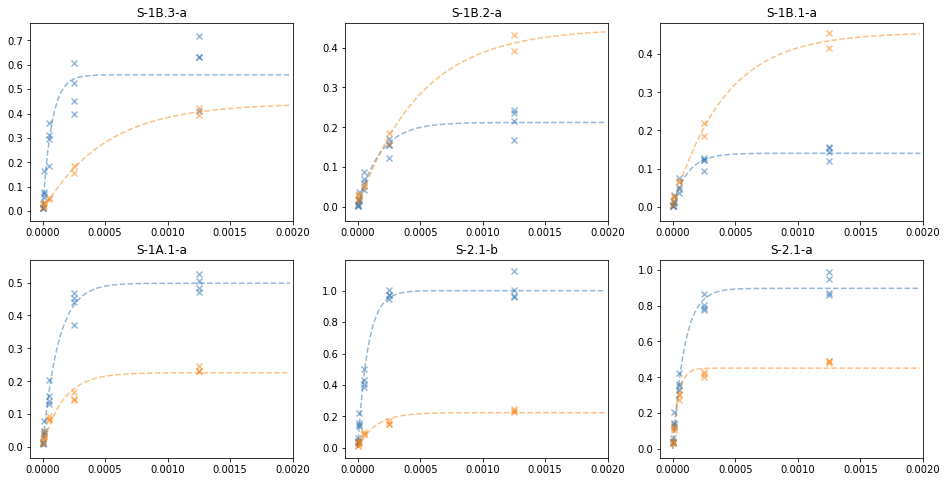

In [337]:
import matplotlib.pyplot as plt

def exp_func(x, A, k):
    return A * (1 - np.exp(- 0.479 * 90 * k * x))  # BTO degradation adjustment and 90 minutes

fig, axes = plt.subplots(2, 3, figsize=(16, 8))

for ix, seqId in enumerate(seqFinished):
    ax = axes[int(ix/3), ix%3]
    ax.set_title(seqId, fontsize=12)
    ### Plot k-seq data
    xdata = np.tile(xValues[:-1], 4)
    ydata = selectedSeq[seqId]['kSeqRes']['reactedFrac']
    ax.scatter(xdata, ydata, marker='x', color='#2C73B4', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, exp_func(x, selectedSeq[seqId]['kSeqRes']['params'][0], selectedSeq[seqId]['kSeqRes']['params'][1]), color='#2C73B4', ls='--', alpha=0.5)
    ax.set_xlim([-0.0001, 0.002])
    
    ### Plot gel data
    shape = np.shape(selectedSeq[seqId]['gelRaw'])
    xdata = np.tile(xValues[:-1], shape[0])
    ydata = np.reshape(selectedSeq[seqId]['gelRaw'][...,:-1], shape[0]*(shape[1]-1))
    ax.scatter(xdata, ydata, marker='x', color='#FC820D', alpha=0.5)
    x = np.arange(0, 0.00200, 0.002/100)
    ax.plot(x, exp_func(x, selectedSeq[seqId]['gelRes']['params'][0], selectedSeq[seqId]['gelRes']['params'][1]), color='#FC820D', ls='--', alpha=0.5)

plt.show()

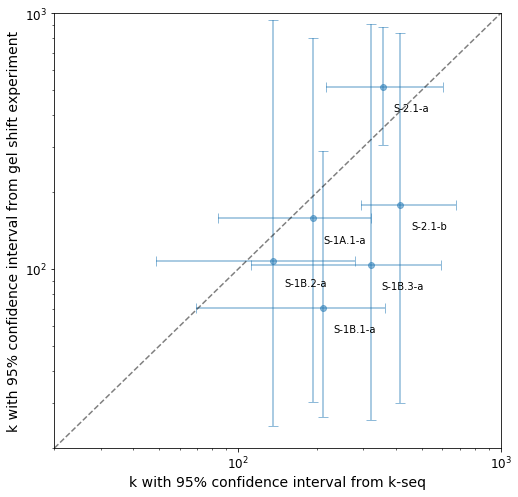

In [373]:
import plot
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=[8, 8])
ax = fig.add_subplot(111)
param=1
reskSeq = [selectedSeq[seqId]['kSeqRes']['ci95'][param][1] for seqId in seqFinished]
reskSeq95 = [(selectedSeq[seqId]['kSeqRes']['ci95'][param][1] - selectedSeq[seqId]['kSeqRes']['ci95'][param][0], selectedSeq[seqId]['kSeqRes']['ci95'][param][2] - selectedSeq[seqId]['kSeqRes']['ci95'][param][1]) for seqId in seqFinished]
resGel = [selectedSeq[seqId]['gelRes']['ci95'][param][1] for seqId in seqFinished]
resGel95 = [(selectedSeq[seqId]['gelRes']['ci95'][param][1] - selectedSeq[seqId]['gelRes']['ci95'][param][0], selectedSeq[seqId]['gelRes']['ci95'][param][2] - selectedSeq[seqId]['gelRes']['ci95'][param][1]) for seqId in seqFinished]
ax.errorbar(x=reskSeq, y=resGel, xerr=np.array(reskSeq95).T, yerr=np.array(resGel95).T, marker='o', linestyle='', capsize=5, alpha=0.5)
plot.set_ticks_size(ax)

for seqId in seqFinished:
    ax.text(s=seqId, x=selectedSeq[seqId]['kSeqRes']['ci95'][param][1]*1.1, y=selectedSeq[seqId]['gelRes']['ci95'][param][1]*0.8)
ax.plot([0, 1000], [0, 1000], 'k--', alpha=0.5)
ax.set_ylim([20, 1000])
ax.set_xlim([20, 1000])
ax.set_yscale('log')
ax.set_xscale('log')
paramDict = {0:'A', 1:'k', 2:'kA'}
ax.set_xlabel('{} with 95% confidence interval from k-seq'.format(paramDict[param]), fontsize=14)
ax.set_ylabel('{} with 95% confidence interval from gel shift experiment'.format(paramDict[param]), fontsize=14)

plt.show()